In [1]:
import pandas as pd
import numpy as np

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy.stats import chisquare, norm, binomtest

from statsmodels.stats.proportion import proportions_ztest

# Общий комментарий по работе

> Очень качественная работа, очень качественный код с функциями и очень четкие рекомендации, а так же выделение основной метрики через логику бизнеса, а не логику теста. \
> Однако если сравнивать с участниками, занявшими 1 и 2 место, то ты **не увидел праздничный день.**

Это ревью после получения ответа. \
Комментарии моего "заднего ума" помечены как **HINDSIGHT**.

> I am going to have to use my secret ability called **"post-cognition"** which allows me to interpret events that have already happened. \
> Hmm, it appears I should have dodged that. (C) [Max0r](https://youtu.be/jqINW3rU6eU?list=PLAbGroPhxb_UuOrlloOP6uc7kf4yBNPB-&t=431)

# Описание

**Поля**:
- `id_order` — уникальный идентификатор заказа.
- `test_group` —  флаг, относящий заказ к контрольной или тестовой группе.
- `time_order` —  дата + время создания заказа.
- `time_offer` — дата + время первого предложения заказа водителю.
- `time_assign` — дата + время согласия и назначения водителя на заказ.
- `time_arrive` — дата + время прибытия водителя в точку «А».
- `trip_time` — дата + время успешного окончания поездки в точке «B».

**Вопросы:**
1. Убедись, что сплит-система А/В теста команды Датапарк работает верно и действительно разбивает выборку в отношении 50 на 50 случайным образом. Предоставь максимально возможное описание кода и аутпут.
1. Рассчитай результаты А/В теста и сделай вывод о том, выгодна ли новая механика с точки зрения продуктовых метрик.
1. В выборке присутствуют также отложенные заказы (не срочные заказы / заказы ко времени), которые команда таксопарка не умеет помечать с помощью флага прямо в таблице. Предложи способ определять отложенные заказы автоматически и изучи их воздействие на А/В тест. 
1. Подготовь презентацию, где объяснишь полученные результаты менеджменту и дашь рекомендации к проведению А/В тестов. 

# Решение

- Весь документ разделен заголовками на смысловые части (и части частей), рекомендуется использовать **Table of Contents** для навигации.
- **EDA** можно пропустить, там больше про парсинг.
    - **HINDSIGHT**: а надо было ещё и про распределения! Обманулся отсутствием числовых полей, не на чем `.describe()` вызвать.
- В каждом **Вопросе** есть **Вывод**, содержащий ответ с качественным описанием результатов конкретного исследования.

Приятного чтения!

## EDA

In [2]:
ds = pd.read_excel(
    "dataset.xlsx",
    header=1
)

ds.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,04.3.2024 0:00:01,04.3.2024 0:00:42,04.3.2024 0:01:13,04.3.2024 0:09:07,04.3.2024 1:27:28
1,10002,0,04.3.2024 0:00:22,04.3.2024 0:01:00,04.3.2024 0:01:14,04.3.2024 0:08:45,04.3.2024 0:22:22
2,10003,1,04.3.2024 0:07:08,04.3.2024 0:07:44,NaN,NaN,NaN
3,10004,1,04.3.2024 0:07:11,04.3.2024 0:08:21,04.3.2024 0:08:46,04.3.2024 0:21:13,04.3.2024 1:23:25
4,10005,0,04.3.2024 0:11:59,04.3.2024 0:12:50,04.3.2024 0:13:09,04.3.2024 0:21:43,04.3.2024 0:46:45


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12281 entries, 0 to 12280
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_order     12281 non-null  int64 
 1   test_group   12281 non-null  int64 
 2   time_order   12281 non-null  object
 3   time_offer   10781 non-null  object
 4   time_assign  9624 non-null   object
 5   time_arrive  7724 non-null   object
 6   trip_time    7384 non-null   object
dtypes: int64(2), object(5)
memory usage: 671.7+ KB


In [4]:
# Посмотрим, в каком формате представлены даты.
date_columns = ds.columns[2:]
for dc in date_columns:
    print(ds[dc].apply(lambda x: str(x).split(" ")[0]).value_counts(), "\n")
#HINDSIGHT: посмотри внимательно на то, как сильно топ-1 дата отстоит от остальных. Подозрительно, не так ли? Что это за дата такая в марте? Хмм...

time_order
08.3.2024    3831
09.3.2024    1900
07.3.2024    1855
10.3.2024    1268
06.3.2024    1187
05.3.2024    1138
04.3.2024    1102
Name: count, dtype: int64 

time_offer
08.3.2024    3300
09.3.2024    1678
07.3.2024    1649
nan          1500
10.3.2024    1129
06.3.2024    1047
05.3.2024    1014
04.3.2024     964
Name: count, dtype: int64 

time_assign
08.3.2024    2706
nan          2657
09.3.2024    1543
07.3.2024    1459
10.3.2024    1101
06.3.2024     940
05.3.2024     852
04.3.2024     793
11.3.2024     150
12.3.2024      55
13.3.2024      25
Name: count, dtype: int64 

time_arrive
nan          4557
08.3.2024    2107
09.3.2024    1244
07.3.2024    1198
10.3.2024     905
06.3.2024     769
05.3.2024     678
04.3.2024     655
11.3.2024     110
12.3.2024      37
13.3.2024      21
Name: count, dtype: int64 

trip_time
nan          4897
08.3.2024    2010
09.3.2024    1191
07.3.2024    1159
10.3.2024     869
06.3.2024     724
05.3.2024     650
04.3.2024     621
11.3.2024     111
12.3

In [5]:
ds = (pd
    .read_excel(
        "dataset.xlsx",
        header=1,
        parse_dates=[2, 3, 4, 5, 6],
        date_format="%d.%m.%Y %H:%M:%S"
    ).rename(columns={"trip_time": "time_trip"})
)

ds.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,time_trip
0,10001,0,2024-03-04 00:00:01,2024-03-04 00:00:42,2024-03-04 00:01:13,2024-03-04 00:09:07,2024-03-04 01:27:28
1,10002,0,2024-03-04 00:00:22,2024-03-04 00:01:00,2024-03-04 00:01:14,2024-03-04 00:08:45,2024-03-04 00:22:22
2,10003,1,2024-03-04 00:07:08,2024-03-04 00:07:44,NaT,NaT,NaT
3,10004,1,2024-03-04 00:07:11,2024-03-04 00:08:21,2024-03-04 00:08:46,2024-03-04 00:21:13,2024-03-04 01:23:25
4,10005,0,2024-03-04 00:11:59,2024-03-04 00:12:50,2024-03-04 00:13:09,2024-03-04 00:21:43,2024-03-04 00:46:45


In [6]:
ds.info() #Сработало!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12281 entries, 0 to 12280
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     12281 non-null  int64         
 1   test_group   12281 non-null  int64         
 2   time_order   12281 non-null  datetime64[ns]
 3   time_offer   10781 non-null  datetime64[ns]
 4   time_assign  9624 non-null   datetime64[ns]
 5   time_arrive  7724 non-null   datetime64[ns]
 6   time_trip    7384 non-null   datetime64[ns]
dtypes: datetime64[ns](5), int64(2)
memory usage: 671.7 KB


In [7]:
#HINDSIGHT: а теперь визуализируем распределение по датам.
ds["date_order"] = ds["time_order"].dt.date

daily_stats = (ds
    .loc[:, ["date_order", "test_group"]]
    .value_counts()
    .sort_index()
    .reset_index()
)

daily_stats

,date_order,test_group,count
0,2024-03-04,0,500
1,2024-03-04,1,602
2,2024-03-05,0,556
3,2024-03-05,1,582
4,2024-03-06,0,535
5,2024-03-06,1,652
6,2024-03-07,0,890
7,2024-03-07,1,965
8,2024-03-08,0,1713
9,2024-03-08,1,2118


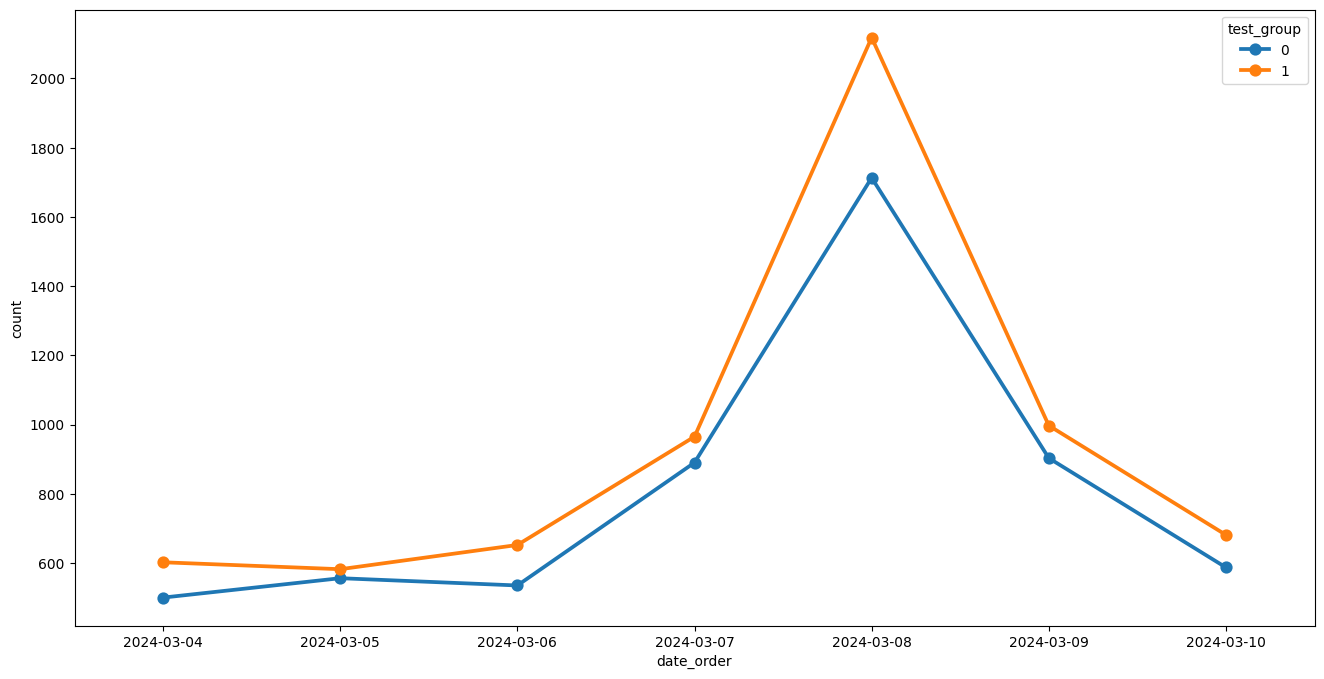

In [8]:
#HINDSIGHT: а теперь >визуализируем< распределение по датам.
plt.rcParams["figure.figsize"] = (16, 8)

sns.pointplot(
    data=daily_stats,
    x="date_order",
    y="count",
    hue="test_group",
    markers="o",
    linestyles="-",
    legend="brief"
)

plt.show()

In [9]:
ds["date_order"] = ds["time_order"].dt.date

daily_stats2 = (ds
    .loc[(ds["date_order"] == date(2024, 3, 8)), ["date_order", "test_group"]]
    .value_counts(normalize=True)
    .sort_index()
    .reset_index()
)

daily_stats2

,date_order,test_group,proportion
0,2024-03-08,0,0.447142
1,2024-03-08,1,0.552858


**HINDSIGHT:** Очень большой пик 8 марта (ожидаемо), причем несбалансированный, попробуем его вырезать.\
Не меняю имя переменной (хотя стоило бы), чтобы не менять очень много кода.

In [10]:
ds = ds.loc[(ds["date_order"] != date(2024, 3, 8)), :]
ds["date_order"].value_counts()

date_order
2024-03-09    1900
2024-03-07    1855
2024-03-10    1268
2024-03-06    1187
2024-03-05    1138
2024-03-04    1102
Name: count, dtype: int64

In [11]:
ds["id_order"].value_counts().agg(["min", "max"]) #`id_order` уникален, это хорошо.

min    1
max    1
Name: count, dtype: int64

In [12]:
ds["test_group"].value_counts(normalize=True) #Разбиение на группы на первый взгляд приблизительно равное (особенно если немного зажмуриться: +-3%).

test_group
1    0.530059
0    0.469941
Name: proportion, dtype: float64

## Вопрос 1.1: сплит-система

**Убедись, что сплит-система А/В теста команды Датапарк работает верно и действительно разбивает выборку в отношении 50 на 50 случайным образом. Предоставь максимально возможное описание кода и аутпут.**

### Конфигурация

In [13]:
alpha = 0.05

test_result_string = "{}test p-value: {} (significant: {})"

n_control, n_treatment = ds["test_group"].value_counts().sort_index()
n_total = ds.shape[0]

n_control, n_treatment, n_total

(3971, 4479, 8450)

### Основной тест

Проверять честность распределения будем через **z-test**, потому что он может напрямую оценить отклонение от указанной константы (0.5 в нашем случае) и идеален в случае разделения на две группы.

Посчитаем вручную и через `statsmodels.stats.proportion.proportions_ztest`.

In [14]:
p_0 = 0.5  # expected proportion
p_hat = n_treatment / n_total

se = sqrt(p_0 * (1.0 - p_0) / n_total)
z_stat = (p_hat - p_0) / se
z_p_value = 2 * (1.0 - norm.cdf(abs(z_stat)))  # Двусторонняя альтернатива

print(test_result_string.format("z-", z_p_value, z_p_value < alpha))

z-test p-value: 3.270333492899624e-08 (significant: True)


In [15]:
zstat2, z_p_value2 = proportions_ztest(n_control, n_total, value=0.5, alternative="two-sided")
print(test_result_string.format("z-", z_p_value2, z_p_value2 < alpha))

zstat3, z_p_value3 = proportions_ztest(n_treatment, n_total, value=0.5, alternative="two-sided")
print(test_result_string.format("z-", z_p_value3, z_p_value3 < alpha))

z-test p-value: 3.0888372388182155e-08 (significant: True)
z-test p-value: 3.0888372388182155e-08 (significant: True)


`p_value < alpha`, следовательно мы отвергаем H0 на уровне значимости alpha: вероятность попадания **заказа** в контрольную группу **не** равна вероятности попадания в экспериментальную группу.

### Дополнительные тесты

"Человек с двумя часами никогда не знает, сколько сейчас времени", но можно также попробовать **биномиальный** (на таких больших `n` практически эквивалентен z-тесту, но при этом остается на них чрезмерно консервативен) и **хи-квадрат** (стабилен на больших `n` и имеет подходящие для наших данных допущения, но также чрезмерно консервативен):

In [16]:
binom_res = binomtest(k=n_treatment, n=n_total, p=0.5, alternative="two-sided")
bin_p_value = binom_res.pvalue

print(test_result_string.format("Binomial ", bin_p_value, bin_p_value < alpha))

Binomial test p-value: 3.447663727729305e-08 (significant: True)


In [17]:
expected = np.array([n_total/2, n_total/2])
observed = np.array([n_control, n_treatment])

chi2_stat, chi2_p_value = chisquare(f_obs=observed, f_exp=expected)

print(test_result_string.format("Chi2 ", chi2_p_value, chi2_p_value < alpha))

Chi2 test p-value: 3.27033348532084e-08 (significant: True)


### Вывод

(До разделения на отложенные и не отложенные заказы) "Сплит-система А/В теста команды Датапарк работает **не**верно и действительно **не** разбивает выборку в отношении 50 на 50 случайным образом": заказов в контрольной группе **статистически значимо меньше**, чем в экспериментальной.

_{Можно сказать, не убедился, задание провалено.}_

Хотелось бы заметить, что всё ещё есть возможность разбития выборки **не по заказам**, а по пользователям (или по водителям [или в особо извращённом случае даже по парам пользователь-водитель]), но в таком случае не повезло: одна группа оказалась значительно плодовитее другой (случалось на практике, никто не застрахован~, берегите себя и своих близких~). Ни подтвердить, ни опровергнуть это замечание на предоставленных данных я не могу, но оно пришло мне в голову, засим делюсь.

## Вопрос 2.0: А/В тест

**Рассчитай результаты А/В теста и сделай вывод о том, выгодна ли новая механика с точки зрения продуктовых метрик.**

Продуктовые метрики:
- order2offer
- offer2assign
- assign2arrive
- arrive2trip

**order2trip**

### Определения и конфигурации

In [18]:
time_cols = ds.columns[2:]

for tc in time_cols:
    colname = tc.replace("time_", "has_")
    ds[colname] = ds[tc].notna()

ds.columns

Index(['id_order', 'test_group', 'time_order', 'time_offer', 'time_assign',
       'time_arrive', 'time_trip', 'date_order', 'has_order', 'has_offer',
       'has_assign', 'has_arrive', 'has_trip'],
      dtype='object')

In [19]:
has_cols = ds.columns[7:]
["test_group", *has_cols]

['test_group',
 'date_order',
 'has_order',
 'has_offer',
 'has_assign',
 'has_arrive',
 'has_trip']

In [20]:
ds.loc[:, ds.columns[7:]].value_counts().sort_index(ascending=False)

date_order  has_order  has_offer  has_assign  has_arrive  has_trip
True        True       True       True        True        True        5257
                                                          False        249
                                              False       False       1223
                                  False       False       False        750
                       False      False       False       False        971
Name: count, dtype: int64

In [21]:
# alpha = 0.05

def calc_metrics(df: pd.DataFrame):
    metrics_df = (df
        .loc[:, ["test_group", *has_cols]]
        .groupby("test_group")[has_cols].agg(["mean", "sum"])
        .rename(columns = lambda x: x.replace("has_", "order2"))
    )
    
    metrics_df.columns = ["_".join(col).replace("_mean", "_perc").replace("_sum", "_cnt") for col in metrics_df.columns.to_flat_index()]
    metrics_df.columns = [col.replace("order2", "") if "_cnt" in col else col for col in metrics_df.columns]

    # metrics_df["order2offer_perc"] = metrics_df["order2offer_perc"]
    metrics_df["offer2assign_perc"] = metrics_df["assign_cnt"] / metrics_df["offer_cnt"]
    metrics_df["assign2arrive_perc"] =  metrics_df["arrive_cnt"] / metrics_df["assign_cnt"]
    metrics_df["arrive2trip_perc"] =  metrics_df["trip_cnt"] / metrics_df["arrive_cnt"]
    # metrics["order2trip_perc"] = metrics["order2trip_perc"]
    
    # metrics_df["offer2assign_perc"] = metrics_df["order2assign_perc"] / metrics_df["order2offer_perc"]
    # metrics_df["assign2arrive_perc"] =  metrics_df["order2arrive_perc"] / metrics_df["order2assign_perc"]
    # metrics_df["arrive2trip_perc"] =  metrics_df["order2trip_perc"] / metrics_df["order2arrive_perc"]
    
    
    metrics_df = metrics_df.loc[:, [
        "order_cnt", "offer_cnt", "assign_cnt", "arrive_cnt", "trip_cnt",
        "order2offer_perc", "offer2assign_perc", "assign2arrive_perc", "arrive2trip_perc",
        "order2trip_perc",
        "order2assign_perc", "order2arrive_perc"
        ]
    ]

    return metrics_df


def add_diff_row(df: pd.DataFrame):
    # if df.shape[0] > 2:
    #     print("Works only for 2-row dataframes!")
    #     return pd.DataFrame([])
    
    df__diff = df.diff().loc[[1], :]
    df__diff.index = [-1]
    
    return pd.concat([df, df__diff])


def add_diff_significance_row(df: pd.DataFrame, funnel_list: list):
    res = []
    
    for fl in funnel_list:
        counts = df.loc[[0, 1], fl[1]].to_list()
        nobs = df.loc[[0, 1], fl[0]].to_list()
        
        z_stat, p_val = proportions_ztest(counts, nobs, alternative="two-sided")

        res.append(p_val)

    res_df = pd.DataFrame(res)
    res_df["p_value"] = res_df < alpha
    res_df = res_df.transpose()
    
    res_df.columns = ["{}2{}_perc".format(fl[0].replace("_cnt", ""), fl[1].replace("_cnt", "")) for fl in funnel_list]
    res_df.index = [-2, -3]

    return pd.concat([df, res_df])


def study_metrics_diff_significance(df: pd.DataFrame, funnel_list: list):
    metrics = calc_metrics(df)
    metrics = add_diff_significance_row(metrics, funnel_list)
    metrics = metrics.loc[: , ["order2offer_perc", "offer2assign_perc", "assign2arrive_perc", "arrive2trip_perc", "order2trip_perc"]]
    metrics = add_diff_row(metrics).sort_index(ascending=False)
    metrics = metrics.transpose().round(4)

    metrics.columns = ["test", "control", "diff", "p_value", "is_significant"]
    metrics["is_significant"] = metrics["is_significant"].astype(np.bool_)
    
    return metrics.loc[:, ["control", "test", "diff", "p_value", "is_significant"]]

### Расчёт

In [22]:
funnel_list = [
    ("order_cnt", "offer_cnt"),
    ("offer_cnt", "assign_cnt"),
    ("assign_cnt", "arrive_cnt"),
    ("arrive_cnt", "trip_cnt"),
    ("order_cnt", "trip_cnt")
]

metrics_funnel = study_metrics_diff_significance(ds, funnel_list)
metrics_funnel

,control,test,diff,p_value,is_significant
order2offer_perc,0.861496,0.906006,0.04451,0.0,True
offer2assign_perc,0.888921,0.908822,0.019901,0.004312,True
assign2arrive_perc,0.876028,0.770607,-0.10542,0.0,True
arrive2trip_perc,0.966216,0.944053,-0.022163,0.000077,True
order2trip_perc,0.648199,0.599018,-0.049182,0.000003,True


### Вывод

Все изменения статистически значимы.

1. `order2offer` **+4.45 pp** (86.15% -> 90.60%) — ожидаемо прилично растёт, "забрасываем б**о**льшую сеть".
2. `offer2assign` **+1.99 pp** (88.89% -> 90.88%) — всё ещё растёт, но гораздо меньше: не каждый "пойманный" водитель готов ехать 5км до заказа.
3. `assign2arrive` **-10.54 pp** (87.60% -> 77.06%) — катастрофа, водители не доезжают до принятой ими точки и/или клиенты устают ждать и отменяют заказ, в любом случае поездка не происходит, полезность теряется.
4. `arrive2trip` **-2.22 pp** (96.62% -> 94.41%) — чуть меньшая катастрофа: скорее всего, клиенты не приходят к ожидающему водителю, возможно, потому что заказали другое такси и забыли отменить это (если не учитывать экстремальный вариант отмены поездки посередине пути _[с последующим выпрыгиванием из движущейся машины]_), опять теряется полезность.

`order2trip` **-4.92 pp** (64.82% -> 59.90%) — опоясывающая метрика "первый-последний шаг" тоже падает: меньше возим, меньше зарабатываем, плохо.

Новая механика с точки зрения продуктовых метрик **невыгодна**.


## Вопрос 3: отложенные заказы

**В выборке присутствуют также отложенные заказы (не срочные заказы / заказы ко времени), которые команда таксопарка не умеет помечать с помощью флага прямо в таблице. Предложи способ определять отложенные заказы автоматически и изучи их воздействие на А/В тест.**

### Обзорное исследование

In [23]:
def study_diff_time(df: pd.DataFrame, col_start: str, col_end: str):
    colname = "{}2{}_time".format(col_start.replace("time_", ""), col_end.replace("time_", ""))

    df[colname] = (df[col_end] - df[col_start]).dt.total_seconds()
    print(df[colname].describe())
    plt.clf()
    sns.histplot(data=df, x=colname, kde=True)
    plt.show()

('time_order', 'time_offer')
count    7479.000000
mean       62.140126
std        24.176607
min         9.000000
25%        44.000000
50%        61.000000
75%        79.000000
max       128.000000
Name: order2offer_time, dtype: float64


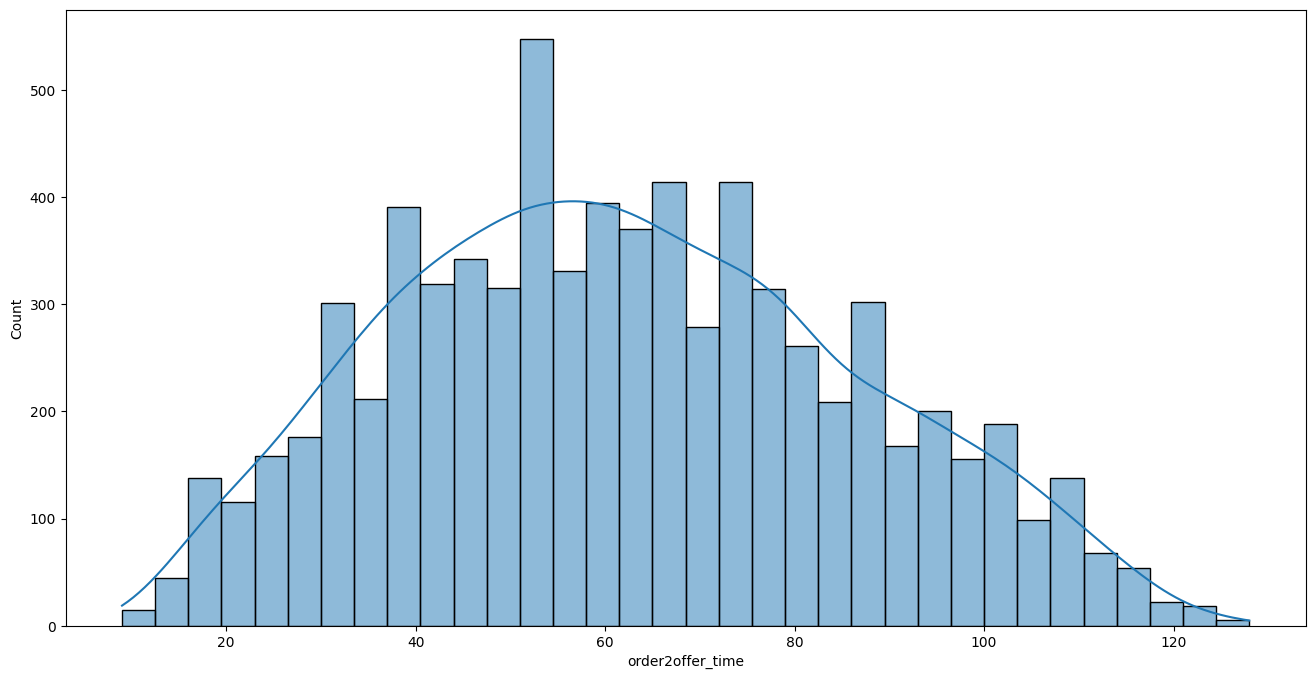



('time_offer', 'time_assign')
count      6729.000000
mean      12124.346411
std       44139.903482
min          13.000000
25%          22.000000
50%          29.000000
75%          37.000000
max      259240.000000
Name: offer2assign_time, dtype: float64


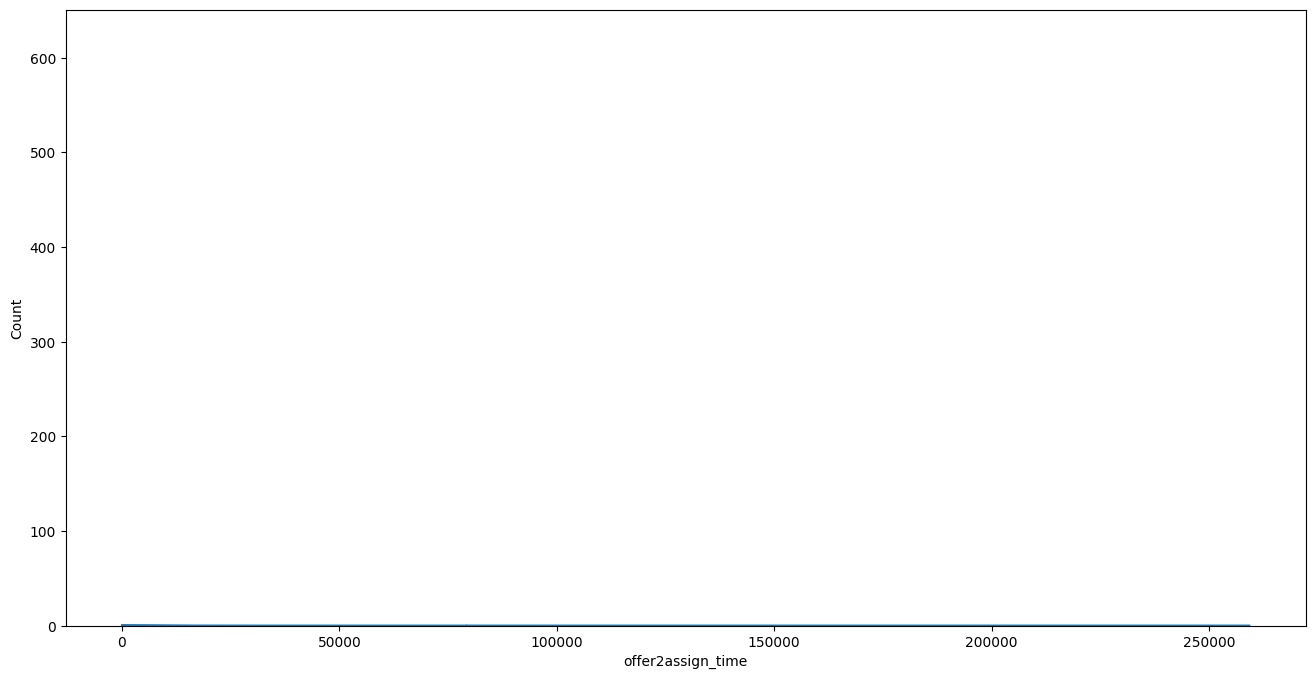



('time_assign', 'time_arrive')
count    5506.000000
mean      465.229568
std       209.430485
min        45.000000
25%       297.000000
50%       461.000000
75%       632.000000
max       963.000000
Name: assign2arrive_time, dtype: float64


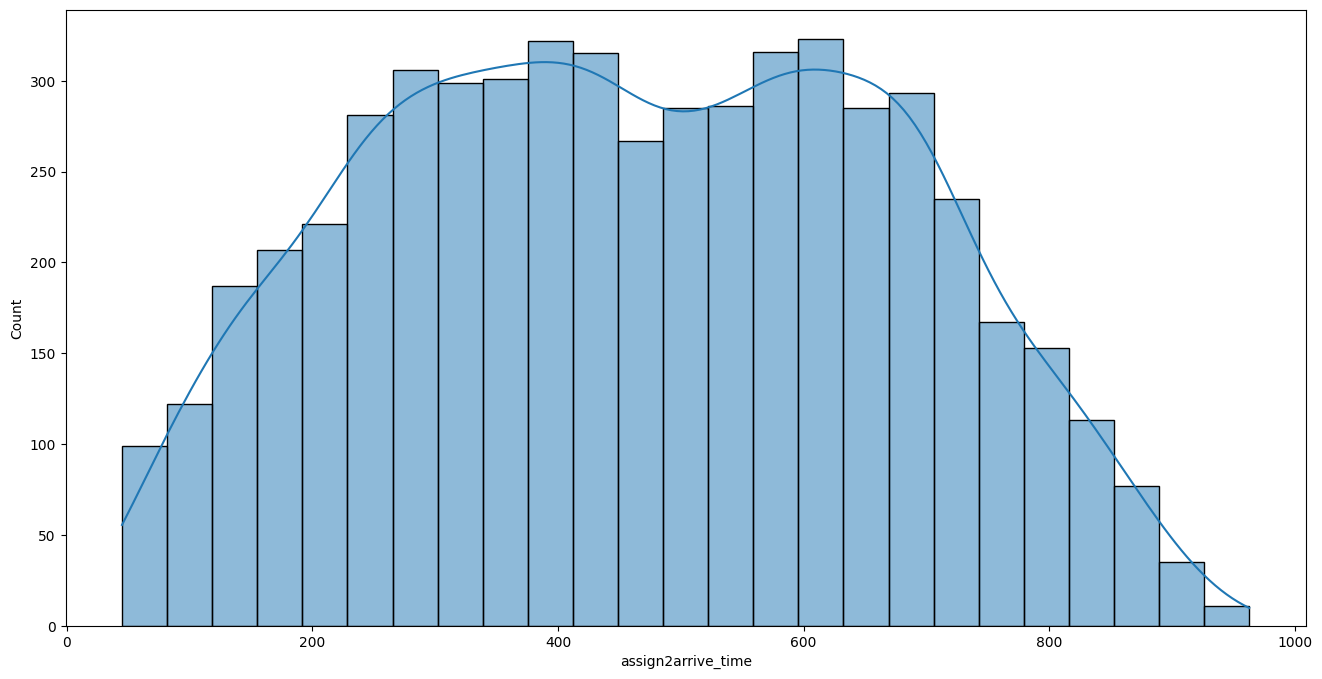



('time_arrive', 'time_trip')
count      5257.000000
mean       2987.189652
std        2684.373367
min         361.000000
25%        1641.000000
50%        2982.000000
75%        4270.000000
max      163902.000000
Name: arrive2trip_time, dtype: float64


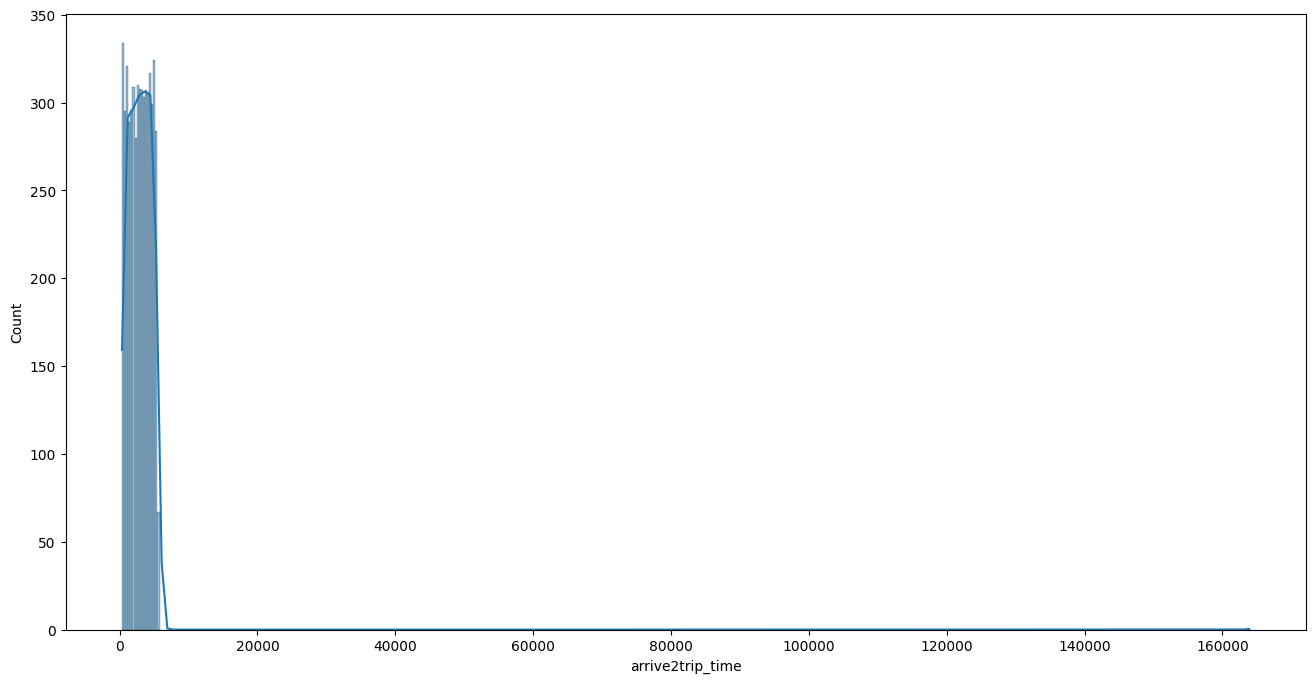

In [24]:
time_funnel_list = [
    ("time_order", "time_offer"),
    ("time_offer", "time_assign"),
    ("time_assign", "time_arrive"),
    ("time_arrive", "time_trip")
]

for tfl in time_funnel_list:
    print(tfl)
    study_diff_time(ds, tfl[0], tfl[1])
    print("\n")

### Подробное исследование

Проблемными оказались `offer2assign_time` и `arrive2trip_time`. Начнем со второго, потому что он выглядит проще (есть хоть какой-то горб).

#### Arrive2Trip

count      5257.000000
mean       2987.189652
std        2684.373367
min         361.000000
25%        1641.000000
50%        2982.000000
75%        4270.000000
max      163902.000000
Name: arrive2trip_time, dtype: float64


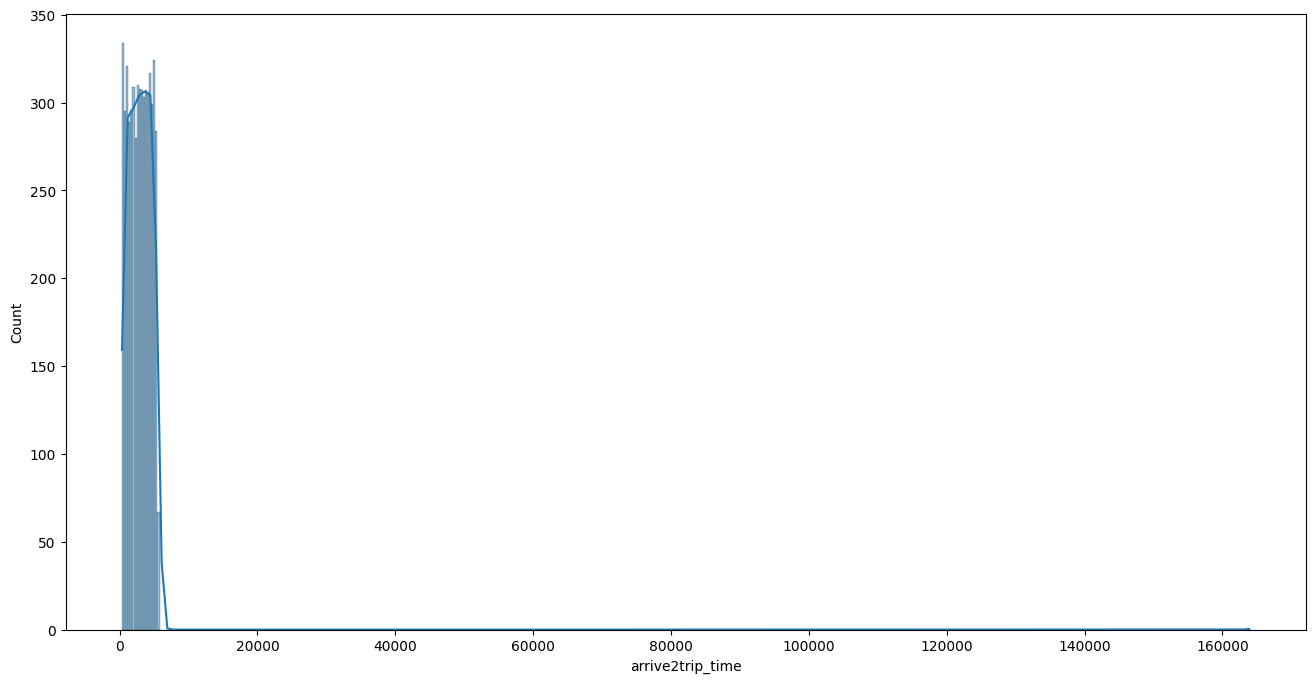

In [25]:
study_diff_time(ds, "time_arrive", "time_trip")

In [26]:
arrive2trip_time__max = ds["arrive2trip_time"].max()

ds.loc[ds["arrive2trip_time"] == arrive2trip_time__max, :]

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,time_trip,date_order,has_order,has_offer,has_assign,has_arrive,has_trip,order2offer_time,offer2assign_time,assign2arrive_time,arrive2trip_time
296,10297,0,2024-03-04 08:26:21,2024-03-04 08:27:42,2024-03-04 08:28:06,2024-03-04 08:31:44,2024-03-06 06:03:26,True,True,True,True,True,True,81.0,24.0,218.0,163902.0


In [27]:
print("{:.2f}h".format(round(arrive2trip_time__max / (60 * 60), 2)))

45.53h


count    5256.000000
mean     2956.574201
std      1509.595031
min       361.000000
25%      1640.750000
50%      2981.000000
75%      4269.250000
max      5580.000000
Name: arrive2trip_time, dtype: float64


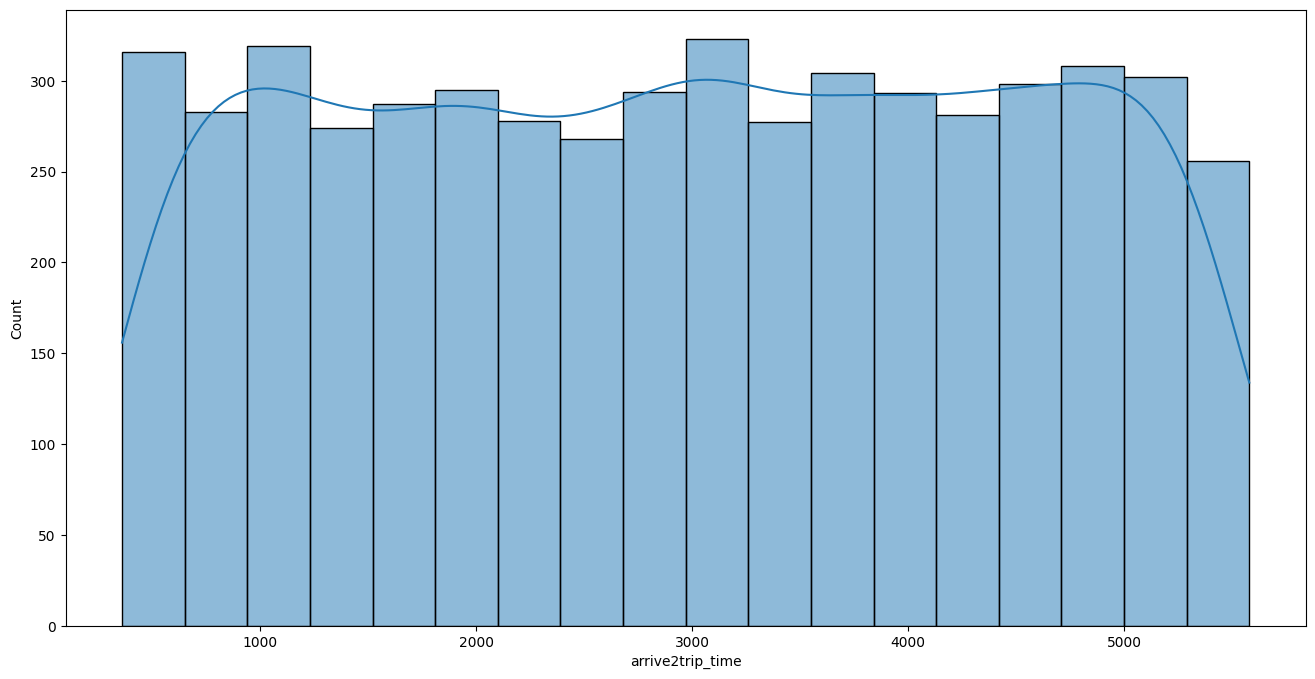

In [28]:
ds_filtered = ds.loc[ds["id_order"] !=  10297, :].copy()

study_diff_time(ds_filtered, "time_arrive", "time_trip")

Этот выброс выглядит как баг (поездка закончилась, но ивент не дошел) или просто нерепрезентативно долгая поездка, поэтому отныне используем `ds_filtered` (для удобства можно было бы перезаписать `ds`, но необходимо помнить, что мы работаем с измененным датасетом, так что явно укажем это в имени переменной).

In [29]:
ds_filtered.shape #Всё правильно, отфильтровали только 1 строку.

(8449, 17)

#### Offer2Assign

count      6728.000000
mean      12126.144917
std       44142.937588
min          13.000000
25%          22.000000
50%          29.000000
75%          37.000000
max      259240.000000
Name: offer2assign_time, dtype: float64


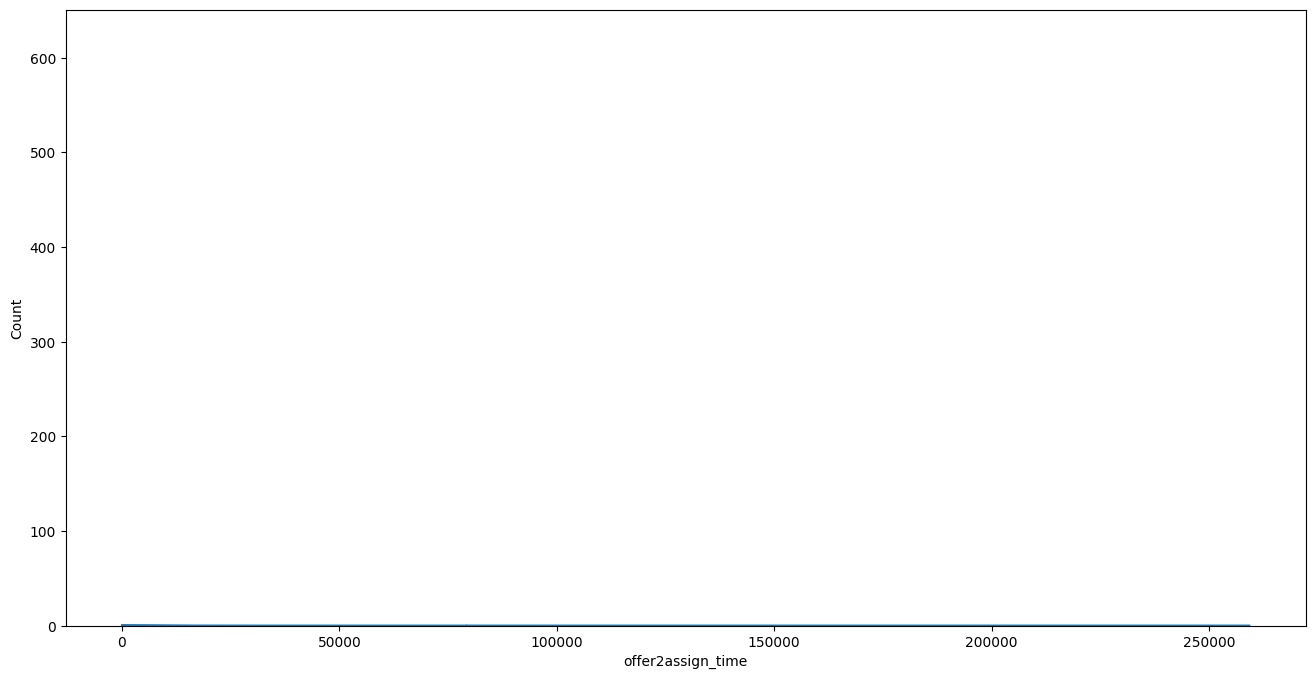

In [30]:
study_diff_time(ds_filtered, "time_offer", "time_assign")

In [31]:
ds_filtered["offer2assign_time"].quantile([0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.99])

0.25        22.00
0.50        29.00
0.75        37.00
0.80        38.00
0.85        40.00
0.90        44.00
0.91     10819.42
0.92     36035.68
0.93     61630.35
0.94     93630.14
0.95    122420.60
0.99    233048.29
Name: offer2assign_time, dtype: float64

In [32]:
ds_filtered["offer2assign_time"].quantile([0.90, 0.9025, 0.9050, 0.90625, 0.9075, 0.91])

0.90000       44.0000
0.90250       44.0000
0.90500       45.0000
0.90625       46.0000
0.90750     2734.6825
0.91000    10819.4200
Name: offer2assign_time, dtype: float64

In [33]:
ds_filtered["offer2assign_time"].value_counts().sort_index().head(40)

offer2assign_time
13.0       32
14.0      156
15.0       61
16.0      269
17.0      127
18.0      133
19.0      351
20.0       77
21.0      311
22.0      293
23.0       71
24.0      364
25.0      188
26.0      152
27.0      394
28.0      112
29.0      284
30.0      325
31.0       76
32.0      348
33.0      194
34.0      151
35.0      420
36.0      119
37.0      248
38.0      372
39.0       35
40.0      179
41.0       85
42.0       35
43.0       92
44.0       19
45.0       21
46.0       11
3619.0      1
3622.0      2
3628.0      1
3633.0      1
3636.0      2
3637.0      1
Name: count, dtype: int64

In [34]:
(ds_filtered["offer2assign_time"] >= 47).value_counts(normalize=False)

offer2assign_time
False    7826
True      623
Name: count, dtype: int64

count    6105.000000
mean       28.073055
std         7.837360
min        13.000000
25%        22.000000
50%        28.000000
75%        35.000000
max        46.000000
Name: offer2assign_time, dtype: float64


/var/folders/4_/rkqmsjm137sc0_sk08cp_ks00000gn/T/ipykernel_59411/3278676520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colname] = (df[col_end] - df[col_start]).dt.total_seconds()


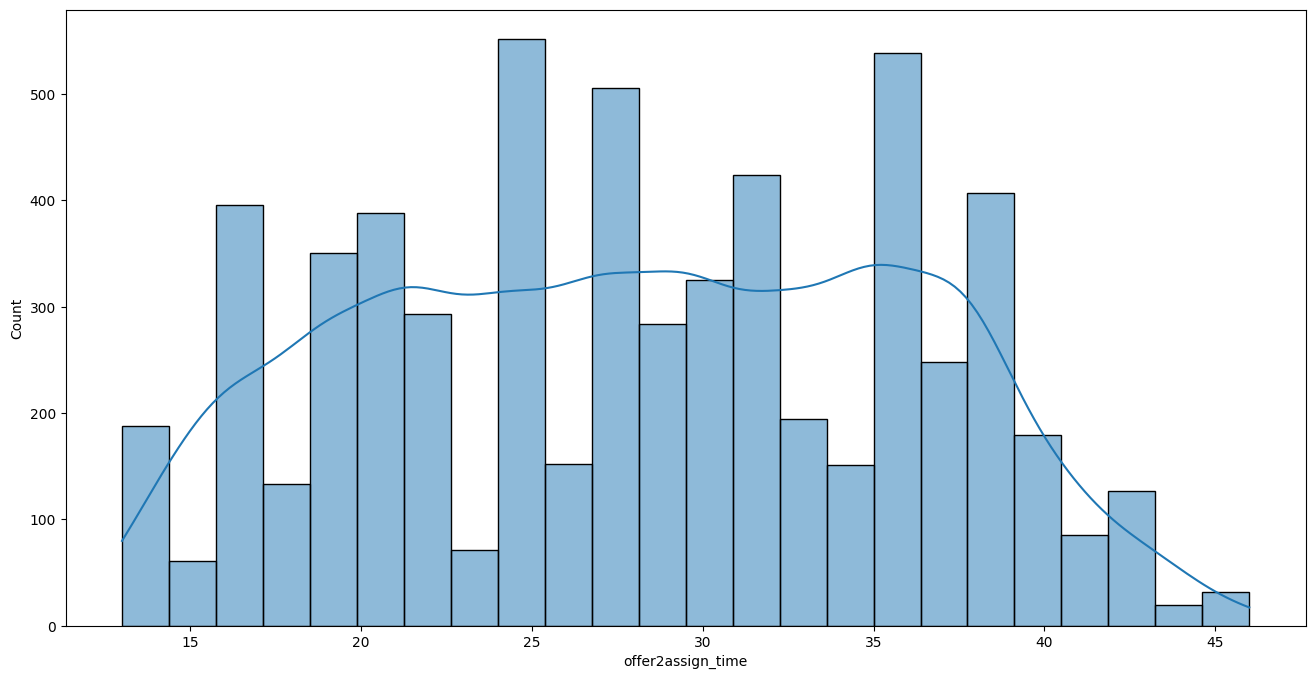

In [35]:
study_diff_time(ds_filtered.loc[ds_filtered["offer2assign_time"] < 47, :], "time_offer", "time_assign")

### Вывод

##### Конкретное решение 

In [36]:
ds_filtered["is_deferred"] = ds_filtered["offer2assign_time"] >= 47

ds_filtered["is_deferred"].value_counts(normalize=True).round(4)

is_deferred
False    0.9263
True     0.0737
Name: proportion, dtype: float64

##### Предложения

1. **Хардкод**: `offer2assign_time >= X`
   1. Любой $X \in [47, 3618]$  ($X=47$ показан выше).
   2. Что-то более осмысленное, вроде 20/40/60/90/120 минут (нужно учитывать, что колонки `*_time` в секундах).
       1. **Плюсы**: простота.
       2. **Минусы**: костыльность, статичность, риск неправильной классификации (особенно без чёткого бизнес-критерия "отложенность/неотложенность").
2. **Перцентиль**: `offer2assign_time >= qN(offer2assign_time)`, где `qN(offer2assign_time)` — значение некоторого перцентиля, в нашем случае это (неловкий) `0.9075`
   1. **Плюсы**: динамичность.
   2. **Минусы**: околокостыльность (внимание на значение), риск ложных срабатываний (стопроцентный в случае отсутствия отложенных заказов в рассматриваемой выборке).
3. **"Первый прыжок"**: располагаем уникальные `offer2assign_time` в ряд и считаем lagged difference, все значения после первого экстремального прыжка (60+ минут) полагаем отложенными.
    1. **Плюсы**: привязка не к статистике, а к качественному изменению длительности.
    2. **Минусы**: сложность понимания/объяснения, риск неправильной классификации (не случился нужный прыжок).

## Вопрос 1.1: сплит-система

**Убедись, что сплит-система А/В теста команды Датапарк работает верно и действительно разбивает выборку в отношении 50 на 50 случайным образом. Предоставь максимально возможное описание кода и аутпут** (теперь учитывая отложенные заказы).

Давайте перепроверим! (Благо, большинство проверок определены функциями, так что копипаста минимальна.)

### Конфигурация

In [37]:
# alpha = 0.05

ds_filtered.loc[:, ["is_deferred", "test_group"]].value_counts().sort_index()

is_deferred  test_group
False        0             3970
             1             3856
True         1              623
Name: count, dtype: int64

In [38]:
n_control, n_treatment = ds_filtered.loc[~ds_filtered["is_deferred"], ["test_group"]].value_counts().sort_index()
n_total = ds_filtered.loc[~ds_filtered["is_deferred"], :].shape[0]

n_control, n_treatment, n_total

(3970, 3856, 7826)

In [39]:
ds_filtered.loc[~ds_filtered["is_deferred"], ["test_group"]].value_counts(normalize=True).sort_index()

test_group
0             0.507283
1             0.492717
Name: proportion, dtype: float64

### Основной тест (отложенные)

Не получится, так как не с чем сравнивать: 100% отложенных заказов находятся в контрольной группе:

In [40]:
ds_filtered.loc[ds_filtered["is_deferred"], "test_group"].value_counts(normalize=True).sort_index()

test_group
1    1.0
Name: proportion, dtype: float64

### Основной тест (не отложенные)

In [41]:
zstat_c, z_p_value_c = proportions_ztest(n_control, n_total, value=0.5, alternative="two-sided")
print(test_result_string.format("z-", z_p_value_c, z_p_value_c < alpha))

zstat_t, z_p_value_t = proportions_ztest(n_treatment, n_total, value=0.5, alternative="two-sided")
print(test_result_string.format("z-", z_p_value_t, z_p_value_t < alpha))

z-test p-value: 0.19747228629488311 (significant: False)
z-test p-value: 0.19747228629488311 (significant: False)


### Вывод

(После разделения на отложенные и не отложенные заказы) "Сплит-система А/В теста команды Датапарк работает верно и действительно разбивает выборку в отношении 50 на 50 случайным образом" для **не отложенных заказов**.

В случае **отложенных** заказов наблюдается идеальная работа, только наоборот _(но при этом не как в анекдоте про угнетение при капитализме и коммунизме)_: 100% попали в контрольную группу.

## Вопрос 2.1: А/В тест (не отложенные)

**Рассчитай результаты А/ В теста и сделай вывод о том, выгодна ли новая механика с точки зрения продуктовых метрик** (теперь учитывая отложенные заказы).

### Расчёт

In [42]:
funnel_list2 = [
    ("order_cnt", "offer_cnt"),
    ("offer_cnt", "assign_cnt"),
    ("assign_cnt", "arrive_cnt"),
    ("arrive_cnt", "trip_cnt"),
    ("order_cnt", "trip_cnt")
]

# metrics_funnel2 = study_metrics_diff_significance(ds.loc[(ds["offer2assign_time"] < 47) | ds["offer2assign_time"].isna(), :], funnel_list2)
metrics_funnel2 = study_metrics_diff_significance(ds_filtered.loc[~ds_filtered["is_deferred"], :], funnel_list2)
metrics_funnel2

,control,test,diff,p_value,is_significant
order2offer_perc,0.861461,0.89082,0.029359,0.000082,True
offer2assign_perc,0.888889,0.892285,0.003396,0.652401,False
assign2arrive_perc,0.875987,0.780424,-0.095563,0.0,True
arrive2trip_perc,0.966204,0.963211,-0.002993,0.564347,False
order2trip_perc,0.648111,0.59751,-0.0506,0.000004,True


### Вывод

#### До

Все изменения статистически значимы.

1. `order2offer` **+4.45 pp** (86.15% -> 90.60%) — ожидаемо прилично растёт, "забрасываем б**о**льшую сеть".
2. `offer2assign` **+1.99 pp** (88.89% -> 90.88%) — всё ещё растёт, но гораздо меньше: не каждый "пойманный" водитель готов ехать 5км до заказа.
3. `assign2arrive` **-10.54 pp** (87.60% -> 77.06%) — катастрофа, водители не доезжают до принятой ими точки и/или клиенты устают ждать и отменяют заказ, в любом случае поездка не происходит, полезность теряется.
4. `arrive2trip` **-2.22 pp** (96.62% -> 94.41%) — чуть меньшая катастрофа: скорее всего, клиенты не приходят к ожидающему водителю, возможно, потому что заказали другое такси и забыли отменить это (если не учитывать экстремальный вариант отмены поездки посередине пути _[с последующим выпрыгиванием из движущейся машины]_), опять теряется полезность.

`order2trip` **-4.92 pp** (64.82% -> 59.90%) — опоясывающая метрика "первый-последний шаг" тоже падает: меньше возим, меньше зарабатываем, плохо.

Новая механика с точки зрения продуктовых метрик **невыгодна**.

#### После

1. `order2offer` **+2.94 pp** (86.15% -> 89.08%, statistically significant) — всё ещё прилично (и ожидаемо) растёт.
2. `offer2assign` **+0.34 pp** (88.89% -> 89.23%, NOT statistically significant) — изменение потеряло значимость, нельзя ничего уверенно сказать об этой метрике.
3. `assign2arrive` **-9.56 pp** (87.60% -> 78.04%, statistically significant) — всё ещё катастрофа, водители не доезжают до принятой ими точки и/или клиенты устают ждать и отменяют заказ, в любом случае поездка не происходит, полезность теряется.
4. `arrive2trip` **-0.30 pp** (96.62% -> 96.32%, NOT statistically significant) — изменение потеряло значимость, нельзя ничего уверенно сказать об этой метрике.

`order2trip` **-5.06 pp** (64.81% -> 59.75%, statistically significant) — опоясывающая метрика "первый-последний шаг" всё ещё падает: меньше возим, меньше зарабатываем, плохо.

Учёт отложенных заказов хоть и оказал влияние на пару значимостей и немного поменял абсолютные значения, но не поменял общие выводы: новая механика с точки зрения продуктовых метрик **невыгодна**.

## Вопрос 4: презентация

**Подготовь презентацию, где объяснишь полученные результаты менеджменту и дашь рекомендации к проведению А/В тестов.**

#### Jumpscare

_Сий документ презентация есть_ (особенно если закрыть все вкладки выше: collapsible headlines — выдающееся достижение Jupyter Notebook). 

![i_am](pics/documentation.jpg)

### Генерация графиков

Решил разделить код и графики, потому что получалось не слишком красиво, а свернуть код, не свернув графики, не могу.

In [43]:
### Chart configs.
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams["legend.markerscale"] = 1.5     # the relative size of legend markers vs. original
plt.rcParams["legend.handletextpad"] = 0.5
plt.rcParams["legend.labelspacing"] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.borderpad"] = 0.5       # border whitespace in fontsize units
plt.rcParams["font.size"] = 10
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["axes.labelsize"] = labelsize
plt.rcParams["axes.titlesize"] = titlesize
plt.rcParams["figure.figsize"] = (11, 7)

plt.rc("xtick", labelsize=xticksize)
plt.rc("ytick", labelsize=yticksize)
plt.rc("legend", fontsize=legendsize)

palette = {
    "control": "#4C72B0",  # blue-ish
    "test":    "#DD8452",  # orange-ish
}

hue_order = ["control", "test"]

In [44]:
metrics_funnel2_melt = metrics_funnel2.reset_index().melt(id_vars = ["index"])
metrics_funnel2_melt.columns = ["metric", "group", "value"]
metrics_funnel2_melt = metrics_funnel2_melt.loc[metrics_funnel2_melt["group"].isin(["control", "test"]), :]

metrics_funnel2_melt["metric"] = metrics_funnel2_melt["metric"].str.replace("_perc", "")

metrics_funnel3 = calc_metrics(ds_filtered.loc[~ds_filtered["is_deferred"], :])

metrics_funnel3 = (metrics_funnel3
    .loc[:, ["order2offer_perc", "order2assign_perc", "order2arrive_perc", "order2trip_perc"]]
    .transpose()
    .reset_index()
)

metrics_funnel3.columns = ["metric", "control", "test"]

metrics_funnel3_melt = metrics_funnel3.reset_index().melt(id_vars = ["metric"])
metrics_funnel3_melt.columns = ["metric", "group", "value"]
metrics_funnel3_melt = metrics_funnel3_melt.loc[metrics_funnel3_melt["group"].isin(["control", "test"]), :]

metrics_funnel3_melt["metric"] = metrics_funnel3_melt["metric"].str.replace("_perc", "")


# metrics_funnel2_melt
# metrics_funnel3_melt

In [45]:
plt.clf()

fig, ax = plt.subplots()

sns.pointplot(
    data=metrics_funnel3_melt,
    x="metric",
    y="value",
    hue="group",
    hue_order=hue_order,
    # palette=palette,
    markers="o",
    linestyles="-",
    legend="brief",
    ax=ax
)

# 1) Remove axis titles & y tick labels
ax.set_xlabel("")   # remove "metric"
ax.set_ylabel("")   # remove "value"
ax.set_yticklabels([])   # hide numeric values on Y
ax.tick_params(axis="y", length=0)  # remove tiny y ticks

if ax.legend_ is not None:
    ax.legend_.set_title("")
if ax.title is not None:
    ax.set_title("Order2Step Сonversion Rates")

# 3) Add point labels (percentages) above each marker
ofs = 0.0155
offsets = [-0.01, 0.005]
has = ["right", "left"]

for (i, line) in enumerate(ax.lines):
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    color  = line.get_color()

    for (x, y) in zip(x_data, y_data):
        if not np.isnan(x) and not np.isnan(y):
            ax.text(
                x,
                y + offsets[i%2], # vertical offset
                f"{y:.2%}",
                ha=has[i%2],
                va="bottom",
                fontsize=10,
                color=color,
                weight="bold"
            )

plt.tight_layout()
# plt.show()
plt.savefig("./pics/order2step__HINDSIGHT.png", dpi=300, bbox_inches="tight")
plt.close()

<Figure size 1100x700 with 0 Axes>

In [46]:
plt.clf()
fig, ax = plt.subplots()

ax = sns.barplot(
    data=metrics_funnel2_melt,
    x="metric",
    y="value",
    hue="group",
    hue_order=hue_order,
    # palette=palette,
    legend="brief",
    ax=ax
)

# 1) Remove axis titles and y numeric labels
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticklabels([])
ax.tick_params(axis="y", length=0)

# 2) Clean legend title
if ax.legend_ is not None:
    ax.legend_.set_title("")
if ax.title is not None:
    ax.set_title("Step2Step Сonversion Rates")

# 3) Add bar labels for both groups
for container in ax.containers:
    # Each container corresponds to one hue level (control/test)
    label_color = container.patches[0].get_facecolor()
    ax.bar_label(
        container,
        fmt="{:.2%}",
        label_type="edge",
        padding=2,
        fontsize=10,
        color=label_color,
        weight="bold"
    )

plt.tight_layout()
# plt.show()
plt.savefig("./pics/step2step__HINDSIGHT.png", dpi=300, bbox_inches="tight")
plt.close()

<Figure size 1100x700 with 0 Axes>

# Презентация

## Результаты А/В

А/В тест неудачен: **изменение негативно сказывается на продуктовых метриках** у не отложенных заказов.

Рассмотрим конверсию всех заказов в некоторый шаг:

![order2step](pics/order2step__HINDSIGHT.png)

Конверсия в `Offer` и `Assign` растёт: увеличение радиуса с 3 км до 5 км увеличивает количество предлагаемых заказов, и больше водителей соглашается на них.

Но это вредные конверсии (можно сказать, "vanity metrics") — конверсии в `Arrive` и `Trip` серьёзно упали: выданные и назначенные заказы **не завершаются**.\
То есть, мы меньше возим и меньше зарабатываем.

Рассмотрим конверсию из шага в шаг (наши продуктовые метрики, согласно воронке №5):

![step2step](pics/step2step__HINDSIGHT.png)

(Здесь и далее "pp" означает "процентные пункты".)

1. `order2offer` статистически значимо **выросла на +2.94 pp**, причина описана выше.
2. `offer2assign` нет статистически значимых изменений (_+0.34 pp_).
3. `assign2arrive` статистически значимо **рухнула на -9.56 pp**, самое большое падение в нашей воронке.
4. `arrive2trip` нет статистически значимых изменений (_-0.30 pp_).
5. `order2trip` статистически значимо **упала на -5.06 pp**, это значит, что в экспериметнальной группе **меньше заказов доходят до конца**.

**Вывод:** изменение радиуса с 3 км до 5 км **негативно сказывается на продуктовых метриках**.\
Распространять эту логику на всех пользователей по итогам этого А/В теста **не рекомендуется**.

## Рекомендации по проведению А/В тестов

### Для менеджмента

1. Предлагаю делить **не по заказам, а по пользователям** — так наши А/В тесты станут более... "клиентоориентированными".
2. Также предлагаю смотреть не только на конверсии, но и на **дополнительные признаки**:
    1. Длительность ожидания (90/95/99-е перцентили `assign2arrive_time`) не должны значительно ухудшаться или хотя бы делать это без веских причин (вертолет, например, можно и подождать {привет, [армянская Yandex Ultima](https://ultima.yandex/ru_am/)}).
    2. Частота использований и retention — "~haters gonna hate~ users gotta use", формируем ли мы привычки у пользователей или гоним их поганой метлой.
    3. Пользовательские оценки (заказа/приложения/чего_другого) — наши изменения никогда не будут **полностью** определять пользовательский опыт, но возможна корреляция, и её желательно не пропускать.


### Не для менеджмента (для инженеров/продактов)

1. Научиться **помечать отложенные заказы**:
    1. Создать другой flow, можно даже отдельный источник для них завести.
    2. Добавить флаг в текущем источнике.
    3. Если нельзя сделать ни того, ни другого, давайте соберёмся и сформулируем определение, которое устроит нас всех и станет общепринятым для компании.
        1. При этом если у нас запускается А/В тест, надо **до его начала** решить, что мы делаем с отложенными заказами:
            1. убираем их
            2. сплитим поровну между контролем и экспериментом
            3. оставляем только их
2. **Следить за выбросами**:
    1. Добавить автообрубание длительности после Х часов.
    2. (Снова) Собраться и сформулировать определение выброса, а после согласиться, что с ним делать (с такими же качествами, как и в пункте 1.С).